# Star Wars emotion classification

Useful readings

- [Analysis of Trump's speeches](https://investigate.ai/upshot-trump-emolex/trump-vs-state-of-the-union-addresses/)
- Documentation of [scikit-learn Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- Download NRC Emotional Lexicon [here](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm)

In [5]:
import os

import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [6]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

## NRC Emotional Lexicon

### Load

In [13]:
filepath = os.path.join(root, "data//NRC-Emotion-Lexicon//NRC-Emotion-Lexicon-wordlevel-v0.92.txt")
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t', keep_default_na=False)
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0


## Star Wars data

### Load

In [23]:
scripts_df = pd.read_csv("star-wars-episodes-1-6-all_text.csv")
scripts_df = scripts_df[['id', 'from', 'to', 'text', 'where', 'number', 'episode']].rename(columns={"text":"text_raw"})


In [24]:
scripts_df.head(4)

,id,from,to,text_raw,where,number,episode
0,1.0,QUI-GON,CAPTAIN,Captain.,INT. REPUBLIC CRUISER - COCKPIT,1,1
1,2.0,CAPTAIN,QUI-GON,"Yes, sir?",INT. REPUBLIC CRUISER - COCKPIT,2,1
2,3.0,QUI-GON,CAPTAIN,Tell them we wish to board at once.,INT. REPUBLIC CRUISER - COCKPIT,8,1
3,4.0,CAPTAIN,QUI-GON,"Yes, sir.",INT. REPUBLIC CRUISER - COCKPIT,2,1


### Clean

In [38]:
# clean where text got added to "TO"
scripts_df.loc[scripts_df['to'].str.find(":")>0, "text_raw" ] = scripts_df[scripts_df['to'].str.find(":")>0]["to"].str.split(":").str[1]
scripts_df.loc[scripts_df['to'].str.find(":")>0, "to" ] = scripts_df[scripts_df['to'].str.find(":")>0]["to"].str.split(":").str[0]

### Prepare

In [168]:
# create scene ids
count = 1
scene = [1]

for i in range(1,len(scripts_df)):
    if scripts_df.loc[i,"where"] != scripts_df.loc[i-1,"where"]:
        count+=1
    scene.append(count)

scripts_df["scene_id"] = scene

,where,episode,text_raw,from,word_count
0,INT. REPUBLIC CRUISER - COCKPIT,1,"Captain.Yes, sir?Tell them we wish to board at...","[QUI-GON, CAPTAIN, QUI-GON, CAPTAIN, CAPTAIN, ...",271
1,INT. FEDERATION BATTLESHIP - DOCKING BAY - SPACE,1,"I'm TC-14 at your service. This way, please.",[TC-14],44
2,INT. FEDERATION BATTLESHIP - CONFERENCE ROOM,1,"We are greatly honored by your visit, Ambassad...","[TC-14, OBI-WAN, QUI-GON, OBI-WAN, QUI-GON, OB...",625
3,INT. FEDERATION BATTLESHIP - BRIDGE,1,What?!? What did you say?The Ambassadors are J...,"[NUTE, TC-14, DOFINE, NUTE, DOFINE]",235
4,INT. FEDERATION BATTLESHIP - CONFERENCE ROOM,1,Is it in their nature to make us wait this lon...,"[OBI-WAN, QUI-GON]",133


In [315]:
# let's aggregate all text per scene
scenes_df = scripts_df.groupby("scene_id").agg({"where": "first", "episode": "first", "text_raw": "sum", "from": list}).reset_index(drop=True)
scenes_df["word_count"] = [len(i) for i in scenes_df["text_raw"]]

# let's add some columns if speakers of interest are present in scene
speakers_of_interest = ["THREEPIO", "ANAKIN", "OBI-WAN", "PADME"]
for speaker in speakers_of_interest:
    scenes_df[speaker] = [1 if speaker in speakers_per_scene else 0 for speakers_per_scene in scenes_df["from"]]

In [316]:
## add text of only ANAKIN per scene
speaker_per_scene = scripts_df.groupby(["scene_id", "from"]).agg({"text_raw": "sum"}).reset_index(drop=False)

# get text of anakin
anakin_per_scene = speaker_per_scene[speaker_per_scene["from"]=="ANAKIN"].set_index(
    "scene_id").drop(columns="from").rename(columns={"text_raw":"text_raw_anakin"})
scenes_df = pd.merge(scenes_df, anakin_per_scene, left_index=True, right_index=True, how="left")

# get text of padme
padme_per_scene = speaker_per_scene[speaker_per_scene["from"]=="PADNE"].set_index(
    "scene_id").drop(columns="from").rename(columns={"text_raw":"text_raw_padme"})
scenes_df = pd.merge(scenes_df, padme_per_scene, left_index=True, right_index=True, how="left")


In [317]:
scenes_df.head()

,where,episode,text_raw,from,word_count,THREEPIO,ANAKIN,OBI-WAN,PADME,text_raw_anakin,text_raw_padme
0,INT. REPUBLIC CRUISER - COCKPIT,1,"Captain.Yes, sir?Tell them we wish to board at...","[QUI-GON, CAPTAIN, QUI-GON, CAPTAIN, CAPTAIN, ...",271,0,0,0,0,NaN,NaN
1,INT. FEDERATION BATTLESHIP - DOCKING BAY - SPACE,1,"I'm TC-14 at your service. This way, please.",[TC-14],44,0,0,0,0,NaN,NaN
2,INT. FEDERATION BATTLESHIP - CONFERENCE ROOM,1,"We are greatly honored by your visit, Ambassad...","[TC-14, OBI-WAN, QUI-GON, OBI-WAN, QUI-GON, OB...",625,0,0,1,0,NaN,NaN
3,INT. FEDERATION BATTLESHIP - BRIDGE,1,What?!? What did you say?The Ambassadors are J...,"[NUTE, TC-14, DOFINE, NUTE, DOFINE]",235,0,0,0,0,NaN,NaN
4,INT. FEDERATION BATTLESHIP - CONFERENCE ROOM,1,Is it in their nature to make us wait this lon...,"[OBI-WAN, QUI-GON]",133,0,0,1,0,NaN,NaN


### Emotion classification

In [349]:
vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=True, 
                     #norm=None
                      norm="l1"  # ELL - ONE
                      )
matrix = vec.fit_transform(scenes_df.text_raw)
vocab = vec.get_feature_names_out()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [350]:
emotions_list = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative',
                'positive', 'sadness', 'surprise', 'trust']

# count number of words per emotion per line in script
for emotion in emotions_list:
    emotion_words = emolex_df[emolex_df[emotion] == 1].word
    scenes_df[emotion] = wordcount_df[emotion_words].sum(axis=1)

scenes_df["scene_id"] = scenes_df.index

<Axes: xlabel='sadness', ylabel='joy'>

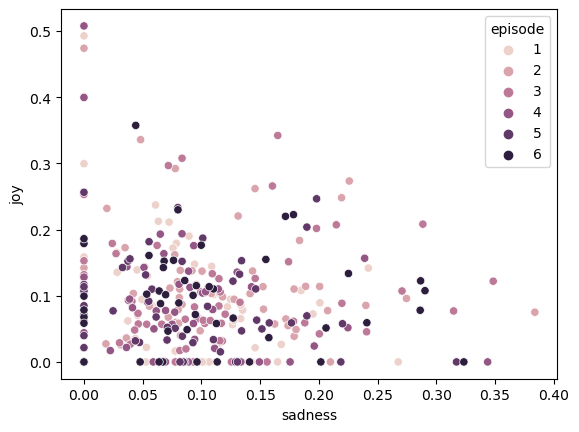

In [351]:
#import seaborn as sns
_filter = scenes_df["word_count"]> 200 

sns.scatterplot(x="sadness", y="joy", hue="episode", data=scenes_df[_filter] )

<Axes: xlabel='scene_id', ylabel='sadness'>

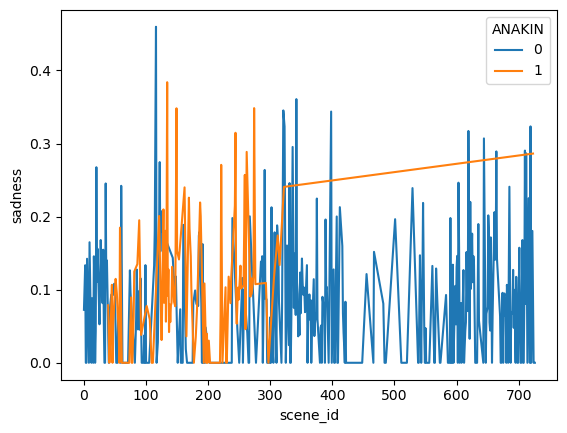

In [352]:
_filter = scenes_df["word_count"]> 100 

sns.lineplot(x="scene_id", y="sadness", hue="ANAKIN", data=scenes_df[_filter])

## Visualise

In [210]:
import matplotlib.pyplot as plt

In [357]:
_filter = scenes_df["word_count"]> 500 
#_filter = ((scenes_df["word_count"]> 200) & (scenes_df["PADME"]==1))
plot_df = scenes_df[_filter][['anger',  'fear', 'sadness', 'anticipation','joy', ]].reset_index(drop=True)

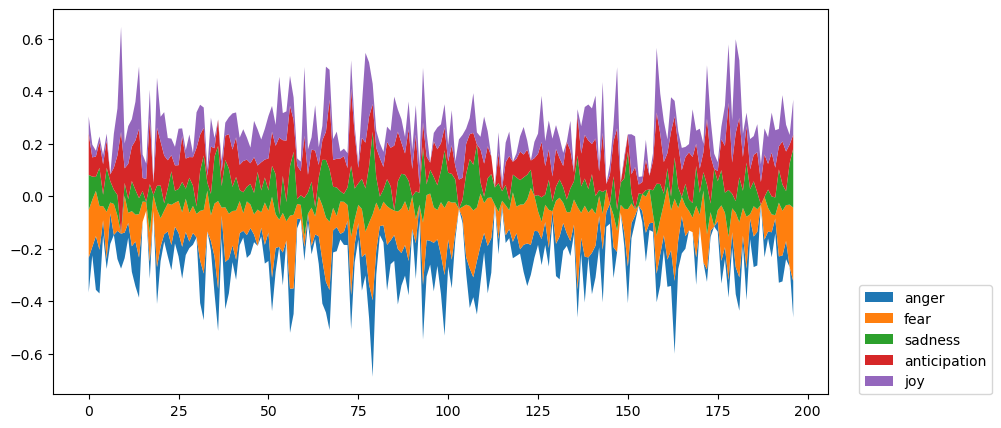

In [358]:
fig, ax = plt.subplots(figsize=(10,5))

# Plot a stackplot - https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/stackplot_demo.html
ax.stackplot(plot_df.index, plot_df.T, baseline='wiggle', labels=plot_df.columns)

# Move the legend off of the chart
ax.legend(loc=(1.04,0))

# Sentiment analysis

In [243]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lisa.hornung\AppData\Roaming\nltk_data...


True

In [244]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
sia.polarity_scores("This restaurant was great, but I'm not sure if I'll go there again.")

{'neg': 0.153, 'neu': 0.688, 'pos': 0.159, 'compound': 0.0276}

In [255]:
scripts_df["PolarityScore"] = [sia.polarity_scores(i)["compound"] for i in scripts_df["text_raw"]]

In [256]:
scripts_df["PolarityScore"].describe()

count    5513.000000
mean        0.040197
std         0.364627
min        -0.980800
25%         0.000000
50%         0.000000
75%         0.273200
max         0.970100
Name: PolarityScore, dtype: float64

<Axes: ylabel='PolarityScore'>

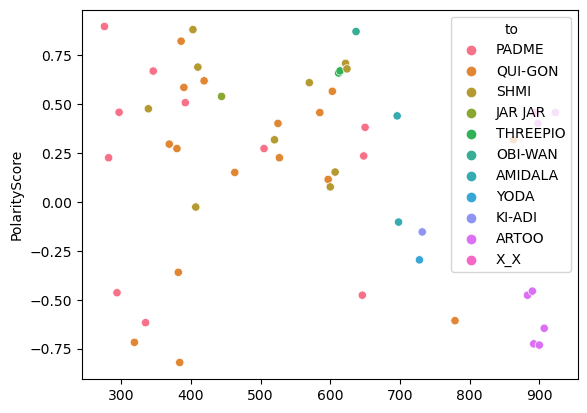

In [272]:

_filter = (scripts_df["from"]=="ANAKIN") & (scripts_df["PolarityScore"] !=0.0)
plot_df = scripts_df[_filter]
#.reset_index(drop=True)
sns.scatterplot(x=plot_df.index, y="PolarityScore", hue="to", data=plot_df)